# 17 Aug 2022: Modeling Home Runs (Regression)

I'm curious to dig into some baseball-related datasets for a change--for starters, I'll use the very straightforward Baseball Databank datasets. Since I'm wondering about batting statistics, I'll begin with the Baseball Databank <code>Batting</code> dataset that compiles offensive stats for every batter since the beginning of time.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

batting = pd.read_csv('../data/baseballdatabank-master/core/Batting.csv')
batting

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,0.0
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,0.0
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,...,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,1.0
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,...,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,0.0
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,...,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110490,zimmejo02,2021,1,MIL,NL,2,1,0,0,0,...,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0
110491,zimmeky01,2021,1,KCA,AL,52,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
110492,zimmery01,2021,1,WAS,NL,110,255,27,62,16,...,46.0,0.0,0.0,16,77.0,0.0,0.0,0.0,2.0,9.0
110493,zuberty01,2021,1,KCA,AL,31,1,0,0,0,...,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0


Now, I've heard that there are more home runs now than ever before. Is it true? For some very simple number-crunching, let's tally up the number of home runs (the <code>HR</code> feature) per year and see.

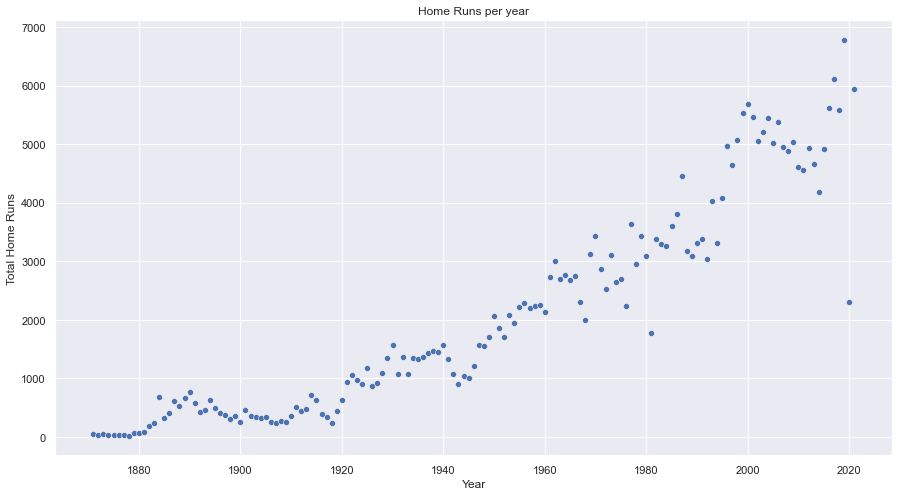

In [2]:
hr_per_year = batting.groupby('yearID')['HR'].sum()

fig, ax = plt.subplots(figsize=(15,8))
sns.scatterplot(data=hr_per_year)
ax.set_title('Home Runs per year')
ax.set_xlabel('Year')
ax.set_ylabel('Total Home Runs');

We can immediately see that, with the exception of the shortened 2020 season, the number of total home runs per year has indeed been increasing.

But let's make sure that we're comparing apples to apples. I don't know enough about baseball to know whether the number of games per season has changed over time, but I'm sure that the number of teams has increased. If there are more teams playing now that a century ago--and certainly, too, if contemporary seasons include more games than historical ones--that might account for the increase in home runs. So let's replot this data in adjusted terms as home runs per game.

To do this, we'll need the <code>Teams</code> dataset compiled by the Baseball Databank, since this one includes the number of games played by each team per season.

In [3]:
teams = pd.read_csv('../data/baseballdatabank-master/core/Teams.csv')
games_per_year = teams.groupby('yearID')['G'].sum()
games_per_year

yearID
1871     254
1872     366
1873     398
1874     464
1875     690
        ... 
2017    4860
2018    4862
2019    4858
2020    1796
2021    4858
Name: G, Length: 151, dtype: int64

Now all we have to do is quickly calculate the number of home runs per game and then chart the result.

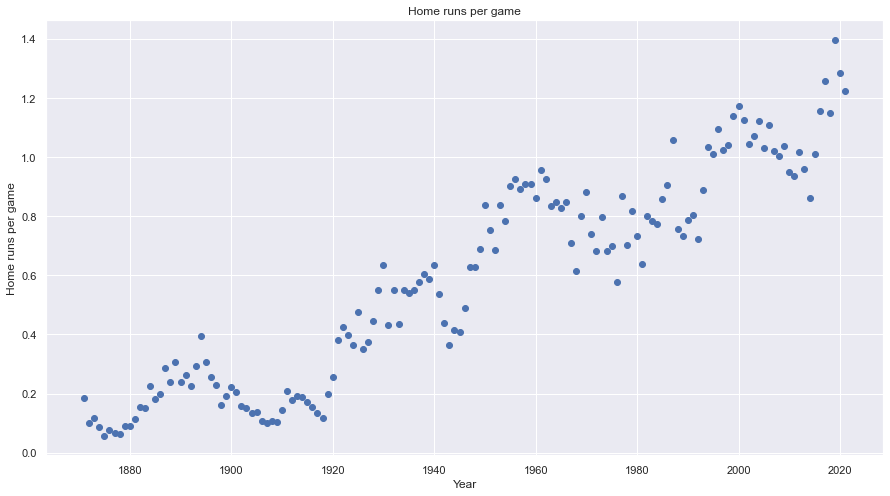

In [4]:
hr_per_game = hr_per_year / games_per_year

fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(hr_per_game.index, hr_per_game.values)
ax.set_title('Home runs per game')
ax.set_xlabel('Year')
ax.set_ylabel('Home runs per game');

The result is somewhat less dramatic but still striking: in recent years, we can expect something around, let's say, 1.2–1.4 home runs per game--easily 3 or 4 times the rate as we could have expected a century ago.

There appears to be a positive linear correlation here between year and home runs per game. Let's do a little regression and see if we can't fit a line to this data.

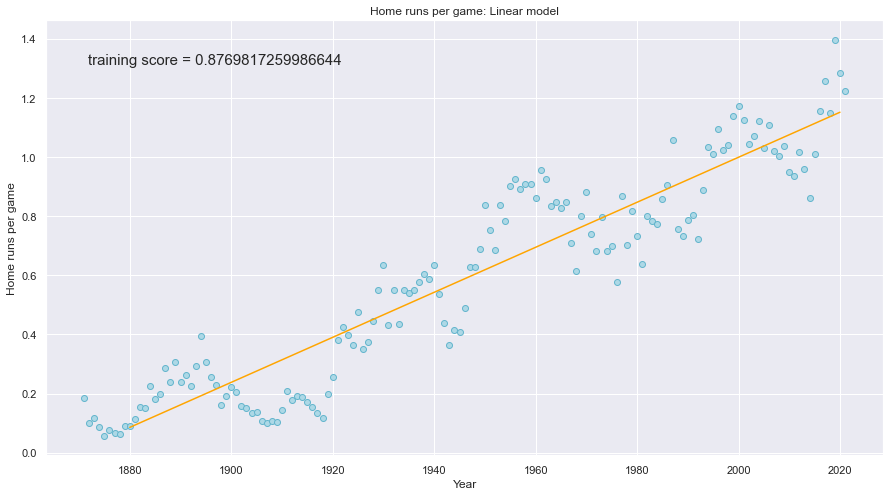

In [5]:
# Import LinearRegression and instantiate model
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# Create feature array, X (years), and target array, y (hrs per game)
x = np.array(hr_per_game.index)
X = x[:, np.newaxis]
y = np.array(hr_per_game.values)

# Fit data to model
model.fit(X, y)

# Generate fit data
x_fit = np.linspace(1880, 2020)
X_fit = x_fit[:, np.newaxis]
y_fit = model.predict(X_fit)

# Plot original datapoints and fit line
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(x, y, c='lightblue', edgecolors='c')
ax.plot(x_fit, y_fit, c='orange')
ax.set_title('Home runs per game: Linear model')
ax.set_xlabel('Year')
ax.set_ylabel('Home runs per game')
ax.text(.05, .9, "training score = {}".format(model.score(X, y)), transform=ax.transAxes, size=15);

That looks like a pretty good fit to me, which is confirmed by the training score of .88.

While this is interesting, it doesn't tell us what's really going on. Let's see if we can dig a little deeper to better understand the reasons behind the increasing home runs. Are players hitting harder? That is, are home runs as a ratio of all hits going up? Are players hitting more often and therefore getting more home runs? Or something else maybe?

While I was happy to manually create a regression model above, moving forward I'll add regression lines using seaborn's <code>regplot</code>.

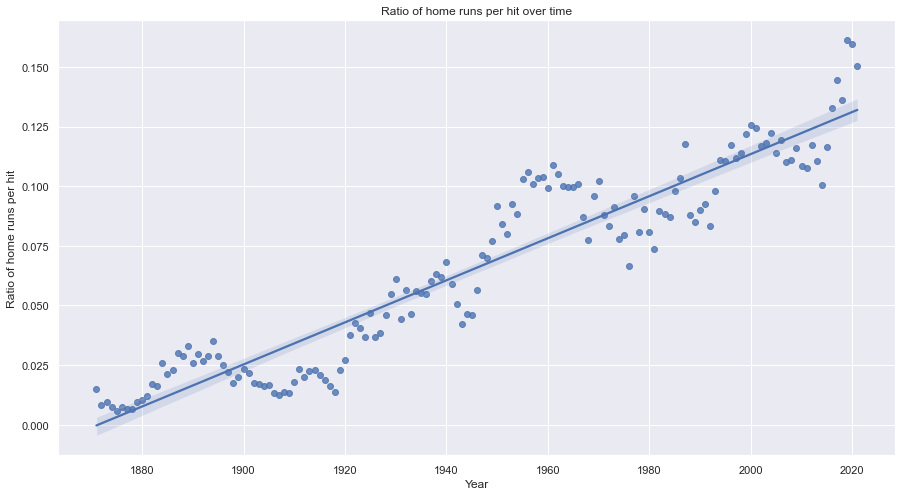

In [6]:
# Calculate hits per year
h_per_year = batting.groupby(by='yearID')['H'].sum()

# Plot HR/H ratio
fig, ax = plt.subplots(figsize=(15, 8))

sns.regplot(x=h_per_year.index, y = hr_per_year / h_per_year, ax=ax)

ax.set_title('Ratio of home runs per hit over time')
ax.set_xlabel('Year')
ax.set_ylabel('Ratio of home runs per hit');

Here we see a very similar pattern, which suggests that one explanation for the increase in home runs is that players are hitting with more power, since home runs constitute an increasing percentage of all hits.

And what about hits per game?

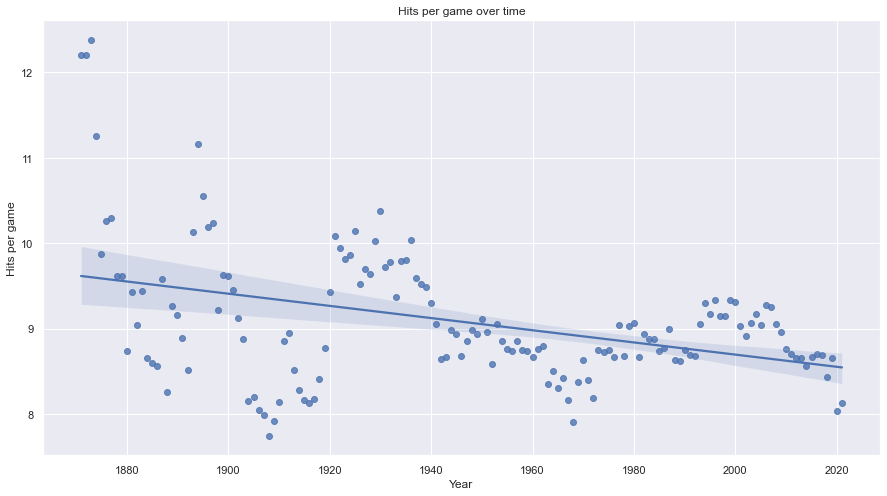

In [7]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.regplot(x=h_per_year.index, y=h_per_year / games_per_year, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Hits per game')
ax.set_title('Hits per game over time');

When it comes to hits per game, we see a negative correlation over time, which seems to confirm what we sensed above: Batters are not simply getting more hits (and therefore hitting more homeruns); instead, it seems they are hitting for power, which means more home runs per hit, but less hits overall (and, we can imagine, very likely more flyouts).

One way to corrobrate this theory might be to see if flyouts per game seem to have an inverse relationship to hits per game--if so, would suggest that batters are increasingly hitting for power, which would mean more home runs per hit but less hits overall (due to players flying out). In the <code>Fielding</code> dataset, we can look at putouts made by outfielders to get a rough estimate.

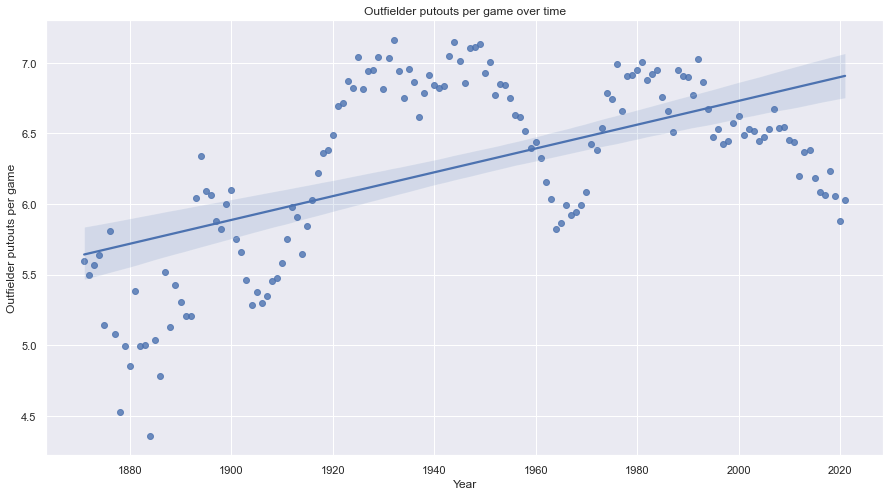

In [8]:
fielding = pd.read_csv('../data/baseballdatabank-master/core/Fielding.csv')

# Filter DataFrame for outfielders
outfield = fielding[fielding['POS'] == 'OF']

# Sum outfielder putouts per year
outfield_putouts = outfield.groupby(by='yearID')['PO'].sum()

# Calculate outfielder putouts per game
outfield_putouts_per_game = outfield_putouts / games_per_year

# Plot
fig, ax = plt.subplots(figsize=(15, 8))
sns.regplot(x=outfield_putouts_per_game.index, y=outfield_putouts_per_game, ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('Outfielder putouts per game')
ax.set_title('Outfielder putouts per game over time');

Well, overall the number of putouts per game made by outfielders does seem to have increased over time, but not quite proportional to the decrease in hits.

This makes me want to look more closely at profile of hits in general: What proportion of hits are singles, doubles, triples, and home runs, and how do these change over time? Perhaps this will give us more insight

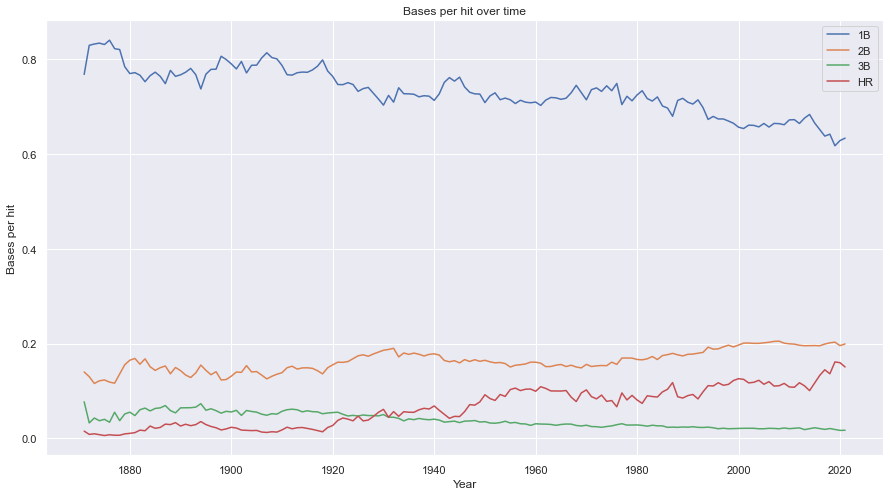

In [9]:
hits_cols = ['H', '2B', '3B', 'HR']
hits = batting.groupby(by='yearID')[hits_cols].sum()

# Calculate singles
hits['1B'] = hits['H'] - hits['2B'] - hits['3B'] - hits['HR']

# Calculate hit type per hit ratio
hits['1B_per_H'] = hits['1B'] / hits['H']
hits['2B_per_H'] = hits['2B'] / hits['H']
hits['3B_per_H'] = hits['3B'] / hits['H']
hits['HR_per_H'] = hits['HR'] / hits['H']

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(hits.iloc[:, -4:], label=['1B', '2B', '3B', 'HR'])

ax.set_xlabel('Year')
ax.set_ylabel('Bases per hit')
ax.set_title('Bases per hit over time')
ax.legend();

While the rate of tripples has slowly decreased, in general I think we can see that extra base hits (doubles, triples, and home runs) account for an increasing share of hits, while singles have decreased over time.

Another way of approaching this question about the reason for the increase in home runs over time is to look at how various hitting stats correlate (or don't) with one another.

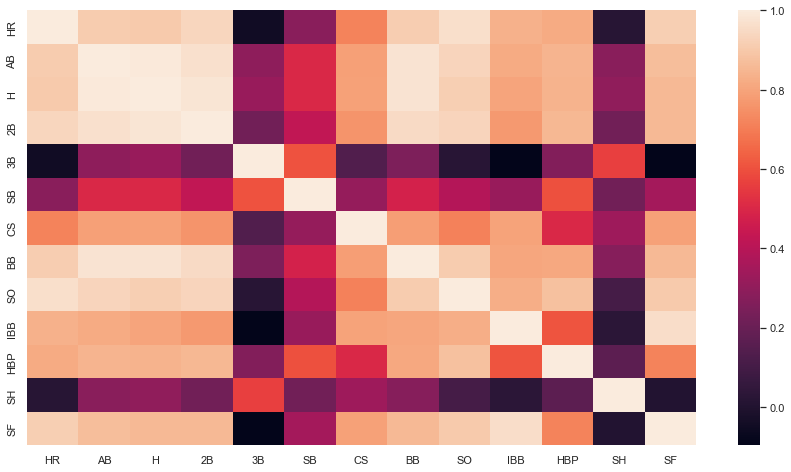

In [94]:
offensive_cols = ['HR', 'AB', 'H', '2B', '3B', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF']

fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(batting.groupby(by=['yearID'])[offensive_cols].sum().corr());

Here we see some things we already discovered--for example, and as we saw above, that home runs are (slightly) correlated with doubles and (slightly) inversly correlated with triples. However, this heatmap also helps see new correlations that are even more striking. For instance, home runs are highly correlated with strike outs, which makes sense: If you're swinging for the fences more often, you're going to whiff more often. (I think?) Home runs are also highly correlated with sac flies--another byproduct of swinging for the fences, I would think.

Perhaps more striking, however, are the inverse correlations: as the number of home runs increases, the number of sacrifice hits goes down dramatically. Same with stolen bases, though less so. As a novice in all things baseball, I interpret this as suggesting less of an emphasis on small ball over time (as indexed by singles, steals, and sacrifice hits) and more of an emphasis, again, on hitting for power--hence not only the increase in home runs per hit but in extra base hits generally.